In [1]:
# import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

from tqdm.notebook import tqdm
from random import shuffle
import torch
from torch import nn
import torch.nn as nn
import torch.nn.functional as F

import math
from glob import glob
import sys
import shutil

import torch.utils.data
import torchvision.transforms as transforms
from torch.autograd import Variable
import PIL
import random
from scipy import ndimage

%matplotlib inline

In [2]:
filename = "/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset"

In [3]:
class segDataset(torch.utils.data.Dataset):
    def __init__(self, root, training, transform=None):
        super(segDataset, self).__init__()
        self.root = root
        self.training = training
        self.transform = transform
        self.IMG_NAMES = sorted(glob(self.root + '/*/images/*.jpg'))

        # Define the BGR color values for different classes in the dataset
        self.BGR_classes = {'Water' : [ 41, 169, 226],
                            'Land' : [246,  41, 132],
                            'Road' : [228, 193, 110],
                            'Building' : [152,  16,  60],
                            'Vegetation' : [ 58, 221, 254],
                            'Unlabeled' : [155, 155, 155]} # in BGR

        # Define the binary classes for segmentation
        self.bin_classes = ['Water', 'Land', 'Road', 'Building', 'Vegetation', 'Unlabeled']


    def __getitem__(self, idx):
        img_path = self.IMG_NAMES[idx]
        mask_path = img_path.replace('images', 'masks').replace('.jpg', '.png')

        # Read the image and its mask using OpenCV
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path)

        # Create a mask for each class based on the color values in the image
        cls_mask = np.zeros(mask.shape)
        cls_mask[mask == self.BGR_classes['Water']] = self.bin_classes.index('Water')
        cls_mask[mask == self.BGR_classes['Land']] = self.bin_classes.index('Land')
        cls_mask[mask == self.BGR_classes['Road']] = self.bin_classes.index('Road')
        cls_mask[mask == self.BGR_classes['Building']] = self.bin_classes.index('Building')
        cls_mask[mask == self.BGR_classes['Vegetation']] = self.bin_classes.index('Vegetation')
        cls_mask[mask == self.BGR_classes['Unlabeled']] = self.bin_classes.index('Unlabeled')
        cls_mask = cls_mask[:,:,0]

        # Apply data augmentation if it's a training dataset
        if self.training==True:
            if self.transform:
              # Apply transformations to the image
              image = transforms.functional.to_pil_image(image)
              image = self.transform(image)
              image = np.array(image)

            # Apply random rotations
            if np.random.rand()<0.5:
              angle = np.random.randint(4) * 90
              image = ndimage.rotate(image,angle,reshape=True)
              cls_mask = ndimage.rotate(cls_mask,angle,reshape=True)

            # Apply vertical flips
            if np.random.rand()<0.5:
              image = np.flip(image, 0)
              cls_mask = np.flip(cls_mask, 0)

            # Apply horizontal flips
            if np.random.rand()<0.5:
              image = np.flip(image, 1)
              cls_mask = np.flip(cls_mask, 1)

        # Resize the image and mask
        image = cv2.resize(image, (512,512))/255.0
        cls_mask = cv2.resize(cls_mask, (512,512))
        image = np.moveaxis(image, -1, 0)

        # Return the image and its corresponding mask as torch tensors
        return torch.tensor(image).float(), torch.tensor(cls_mask, dtype=torch.int64)


    def __len__(self):
        # Return the total number of images in the dataset
        return len(self.IMG_NAMES)

In [4]:
# Define color shift transformation
color_shift = transforms.ColorJitter(.1,.1,.1,.1)

# Define blurriness transformation
blurriness = transforms.GaussianBlur(3, sigma=(0.1, 2.0))

# Compose the transformations
t = transforms.Compose([color_shift, blurriness])
dataset = segDataset(filename, training = True, transform= t)

# Get the length of the dataset
print(f"Length of the dataset: {len(dataset)}")

Length of the dataset: 72


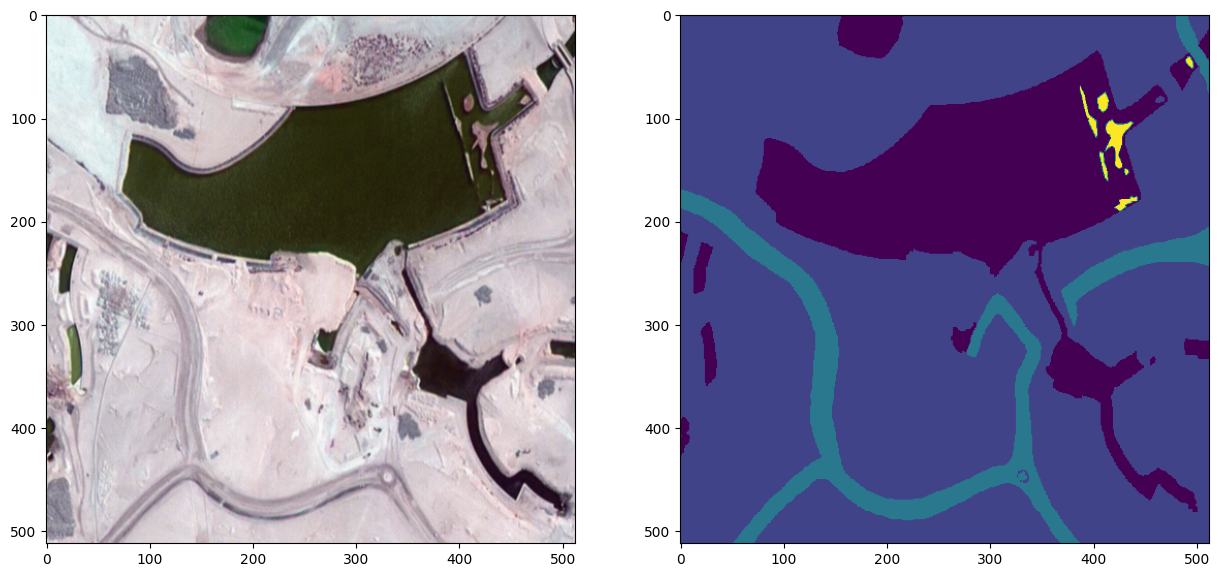

In [5]:
# Plotting an image
d = dataset[1]
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(np.moveaxis(d[0].numpy(),0,-1))
plt.subplot(1,2,2)
plt.imshow(d[1].numpy())

In [6]:
# Calculate the number of samples for the test set (10% of the total dataset)
test_num = int(0.1 * len(dataset))

# Print the number of samples in the test set
print(f'test data : {test_num}')

# The first part is for training and the second part is for testing
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset)-test_num, test_num], generator=torch.Generator().manual_seed(101))

BATCH_SIZE = 4

# Create a DataLoader for the training dataset
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# Create a DataLoader for the test dataset
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test data : 7


In [7]:
# Function to get the default device available (GPU if available, else CPU)
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

# Function to move data to the specified device
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

# Wrapper class for DataLoader to move batches of data to the specified device
class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)

# Get the default device
device = get_default_device()

# Move the training and test DataLoader batches to the selected device
train_dataloader = DeviceDataLoader(train_dataloader, device)
test_dataloader = DeviceDataLoader(test_dataloader, device)

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [9]:
# Define the DoubleConv block, which consists of two convolutional layers followed by batch normalization and ReLU activation
class DoubleConv(nn.Module):
    """
    (convolution => [BN] => ReLU) * 2
    """
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# Define the Down block, which downscales the input using max pooling followed by a DoubleConv block
class Down(nn.Module):
    """
    Downscaling with maxpool then double conv
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

# Define the Up block, which upscales the input and concatenates it with the skip connection from the encoder, followed by a DoubleConv block
class Up(nn.Module):
    """
    Upscaling then double conv
    """
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

         # If bilinear interpolation is used, upscale using bilinear interpolation and reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            # Otherwise, use transposed convolution for upscaling
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Calculate the difference in size between the input and the skip connection
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        # Pad the input to match the size of the skip connection
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # Concatenate the skip connection with the upscaled input
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

# Define the final output convolution layer
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [10]:
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.7 MB/s eta 0:00:00


In [11]:
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# Function to ensure the input is a tuple
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# Pre-Normalization module
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

# Feed Forward Neural Network module
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

# Attention mechanism module
class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

# Transformer module
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

# Vision Transformer class
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, dim, depth, heads, mlp_dim, pool = 'cls', channels = 512, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        # Check if image dimensions are divisible by patch dimensions
        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        # Calculate number of patches and patch dimension
        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        # Patch embedding layer
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        # Positional embedding
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        # Transformer
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()


    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)
        x = self.transformer(x)
        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]
        x = self.to_latent(x)
        return x

In [12]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # Encoder (Contracting Path)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)

        # Vision Transformer block
        self.vit = ViT(image_size = 32,patch_size = 8,dim = 2048, depth = 2, heads = 16,mlp_dim = 12,channels = 512)
        self.vit_conv = nn.Conv2d(32,512,kernel_size = 1,padding = 0)
        self.vit_linear = nn.Linear(64,1024)

        # Decoder (Expanding Path)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        # Encoder (Contracting Path)
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        #applying Vision Transformer
        x6 = self.vit(x5)
        x6 = torch.reshape(x6,(-1,32,8,8))
        x7 = self.vit_conv(x6)
        x8 = self.vit_linear(torch.reshape(x7,(-1,512,64)))
        x9 = torch.reshape(x8,(-1,512,32,32))

        # Decoder (Expanding Path)
        x = self.up1(x9, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [13]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

        # If alpha is a single value (float or int), convert it to a tensor
        if isinstance(alpha,(float,int)):
          self.alpha = torch.Tensor([alpha,1-alpha])

        # If alpha is a list, convert it to a tensor
        if isinstance(alpha,list):
           self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            # If input has more than 2 dimensions (e.g., image), reshape it for calculation
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input, dim=-1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            # If alpha is specified, weight the loss for each class
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        # Compute the focal loss
        loss = -1 * (1-pt)**self.gamma * logpt

        # Calculate the mean loss if size_average is True, else sum the loss
        if self.size_average:
          return loss.mean()
        else: return loss.sum()

In [14]:
criterion = FocalLoss(gamma=3/4).to(device)

In [15]:
# Define accuracy function
def acc(label, predicted):
  seg_acc = (y.cpu() == torch.argmax(pred_mask, axis=1).cpu()).sum() / torch.numel(y.cpu())
  return seg_acc

# Define precision function
def precision(y, pred_mask, classes = 6):
    precision_list = [];
    for i in range(classes):
        # Compute precision for each class
        actual_num = y.cpu() == i
        predicted_num = i == torch.argmax(pred_mask, axis=1).cpu()

        # Calculate precision for class i
        prec = torch.logical_and(actual_num,predicted_num).sum()/predicted_num.sum()
        precision_list.append(prec.numpy().tolist())
    return precision_list

# Define recall function
def recall(y, pred_mask, classes = 6):
    recall_list = []
    for i in range(classes):
        # Compute recall for each class
        actual_num = y.cpu() == i
        predicted_num = i == torch.argmax(pred_mask, axis=1).cpu()

        # Calculate recall for class i
        recall_val = torch.logical_and(actual_num, predicted_num).sum() / actual_num.sum()
        recall_list.append(recall_val.numpy().tolist())
    return recall_list

In [16]:
# Initialize minimum loss as infinity
min_loss = torch.tensor(float('inf'))

# Initialize UNet model with specified number of input channels, output classes, and bilinear interpolation flag
model = UNet(n_channels=3, n_classes=6, bilinear=True).to(device)

# Initialize Adam optimizer for training the model with a learning rate of 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Initialize learning rate scheduler to adjust learning rate during training
# StepLR reduces the learning rate by a factor of 0.5 every epoch
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

In [17]:
# Create a directory to save trained models if it doesn't exist
os.makedirs('./saved_models', exist_ok=True)

# Number of epochs for training
N_EPOCHS = 10

# Number of samples in the training and testing datasets
N_DATA = len(train_dataset)
N_TEST = len(test_dataset)

# List to store losses for plotting
plot_losses = []

# Counter for the scheduler
scheduler_counter = 0

for epoch in range(N_EPOCHS):
  # Set model to training mode
  model.train()

  # Lists to store losses and accuracies for each batch
  loss_list = []
  acc_list = []

  # Iterate over batches in the training dataset
  for batch_i, (x, y) in enumerate(train_dataloader):

      # Forward pass: compute predicted outputs by passing inputs to the model
      pred_mask = model(x.to(device))

      # Calculate the loss
      loss = criterion(pred_mask, y.to(device))

      # Zero the gradients, perform a backward pass, and update the weights
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Append the loss and accuracy to the respective lists
      loss_list.append(loss.cpu().detach().numpy())
      acc_list.append(acc(y,pred_mask).numpy())

      # Print progress
      sys.stdout.write(
          "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f)]"
          % (
              (epoch + 1),
              N_EPOCHS,
              batch_i,
              len(train_dataloader),
              loss.cpu().detach().numpy(),
              np.mean(loss_list),
          )
      )

  # Increment scheduler counter
  scheduler_counter += 1

  # Set model to evaluation mode
  model.eval()

  # Lists to store validation losses and accuracies for each batch
  val_loss_list = []
  val_acc_list = []

  # Iterate over batches in the test dataset
  for batch_i, (x, y) in enumerate(test_dataloader):
      with torch.no_grad():
          # Forward pass: compute predicted outputs by passing inputs to the model
          pred_mask = model(x.to(device))

      # Calculate the validation loss
      val_loss = criterion(pred_mask, y.to(device))

      # Append the validation loss and accuracy to the respective lists
      val_loss_list.append(val_loss.cpu().detach().numpy())
      val_acc_list.append(acc(y,pred_mask).numpy())

  # Print epoch statistics
  print(' epoch {} - loss : {:.5f} - acc : {:.2f} - val loss : {:.5f} - val acc : {:.2f}'.format((epoch + 1),
                                                                                                 np.mean(loss_list),
                                                                                                 np.mean(acc_list),
                                                                                                 np.mean(val_loss_list),
                                                                                                 np.mean(val_acc_list)))
  # Append epoch losses for plotting
  plot_losses.append([epoch, np.mean(loss_list), np.mean(val_loss_list)])

  # Check if the current validation loss is the lowest encountered so far
  compare_loss = np.mean(val_loss_list)
  is_best = compare_loss < min_loss

  # If the current loss is the lowest, save the model
  if is_best == True:
    scheduler_counter = 0
    min_loss = min(compare_loss, min_loss)
    torch.save(model.state_dict(), './saved_models/unet_epoch_{}_{:.5f}.pt'.format(epoch,np.mean(val_loss_list)))

  # If the scheduler counter exceeds a certain threshold, adjust the learning rate
  if scheduler_counter > 5:
    lr_scheduler.step()
    print(f"lowering learning rate to {optimizer.param_groups[0]['lr']}")
    scheduler_counter = 0

[Epoch 1/10] [Batch 16/17] [Loss: 1.326010 (1.019852)] epoch 1 - loss : 1.01985 - acc : 0.59 - val loss : 1.00730 - val acc : 0.62
[Epoch 2/10] [Batch 16/17] [Loss: 0.976141 (0.805490)] epoch 2 - loss : 0.80549 - acc : 0.68 - val loss : 0.82179 - val acc : 0.68
[Epoch 3/10] [Batch 16/17] [Loss: 1.083134 (0.773051)] epoch 3 - loss : 0.77305 - acc : 0.68 - val loss : 0.80516 - val acc : 0.66
[Epoch 4/10] [Batch 16/17] [Loss: 0.832549 (0.710816)] epoch 4 - loss : 0.71082 - acc : 0.71 - val loss : 0.62400 - val acc : 0.73
[Epoch 5/10] [Batch 16/17] [Loss: 1.010615 (0.695864)] epoch 5 - loss : 0.69586 - acc : 0.70 - val loss : 0.67904 - val acc : 0.70
[Epoch 6/10] [Batch 16/17] [Loss: 1.050133 (0.751383)] epoch 6 - loss : 0.75138 - acc : 0.68 - val loss : 0.62041 - val acc : 0.72
[Epoch 7/10] [Batch 16/17] [Loss: 0.824561 (0.734586)] epoch 7 - loss : 0.73459 - acc : 0.68 - val loss : 0.62191 - val acc : 0.73
[Epoch 8/10] [Batch 16/17] [Loss: 1.499495 (0.756301)] epoch 8 - loss : 0.75630 - a

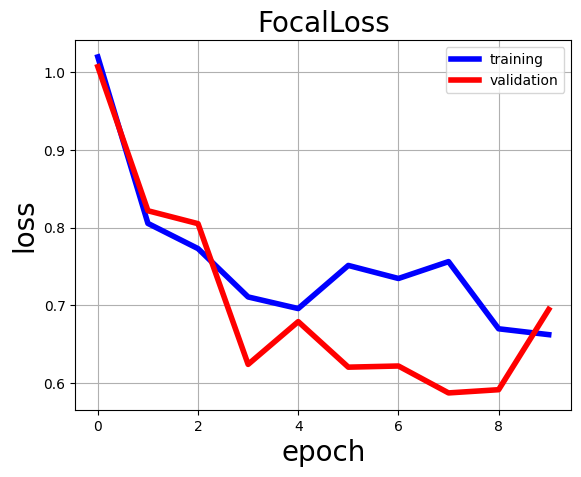

In [18]:
# Plot the focalloss
plot_losses = np.array(plot_losses)
plt.plot(plot_losses[:,0], plot_losses[:,1], color='b', linewidth=4)
plt.plot(plot_losses[:,0], plot_losses[:,2], color='r', linewidth=4)
plt.title('FocalLoss', fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.ylabel('loss',fontsize=20)
plt.grid()
plt.legend(['training', 'validation'])
plt.show()

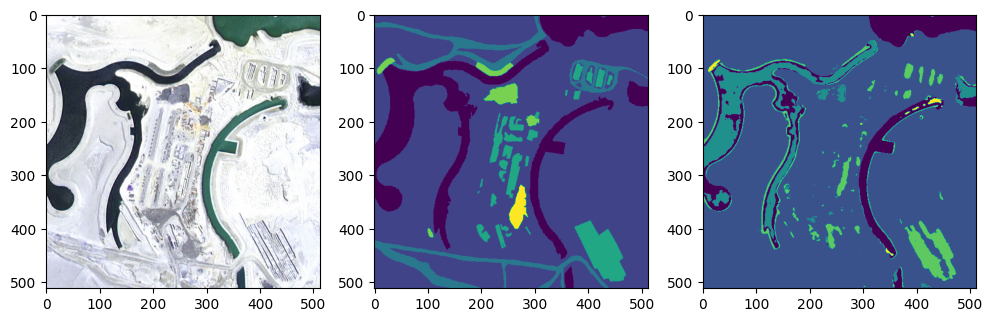

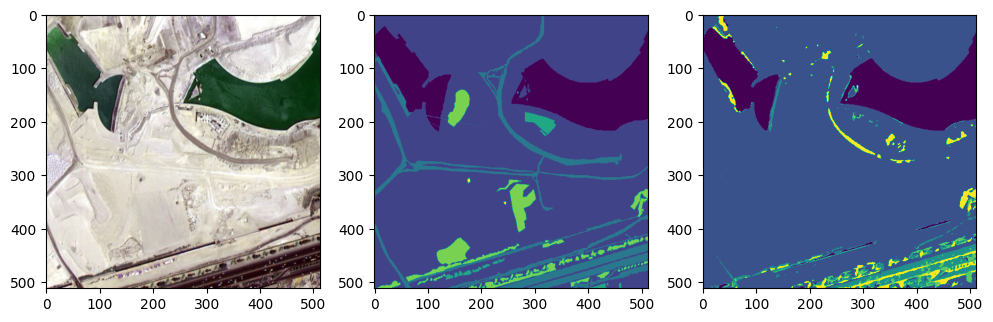

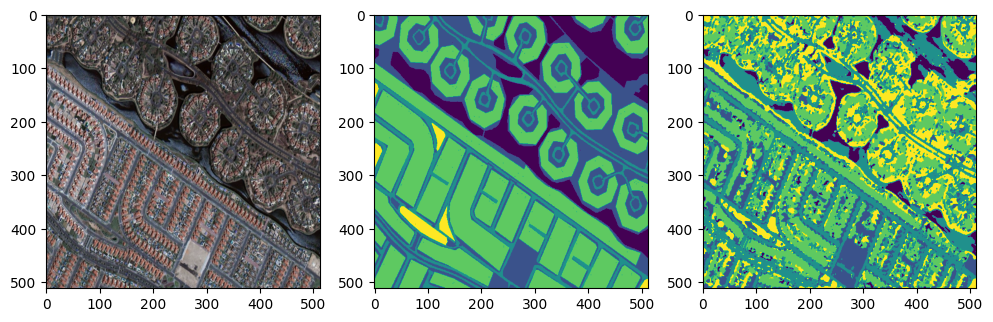

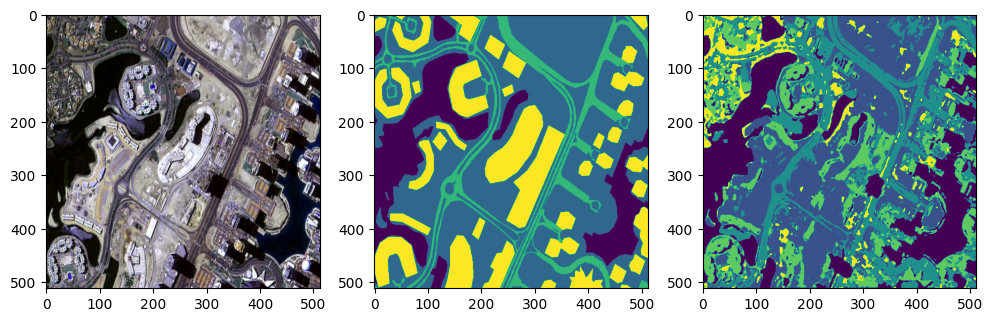

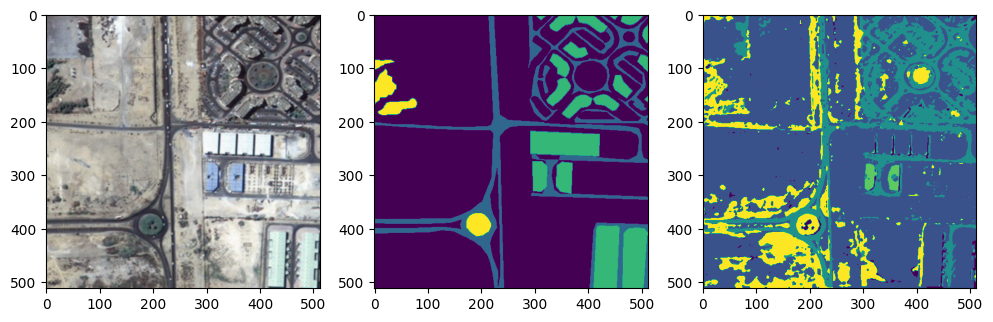

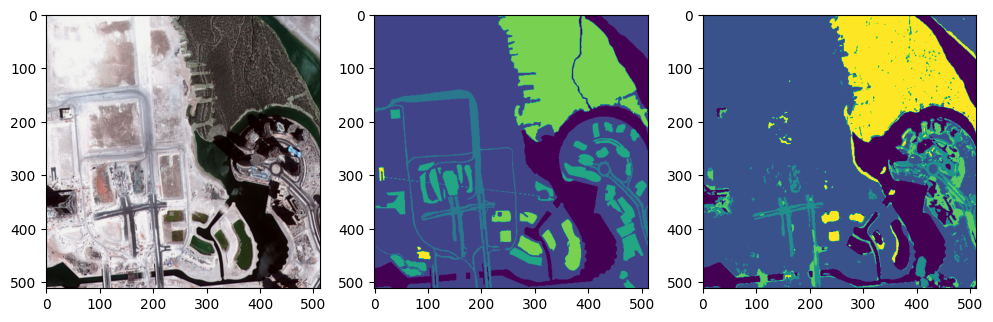

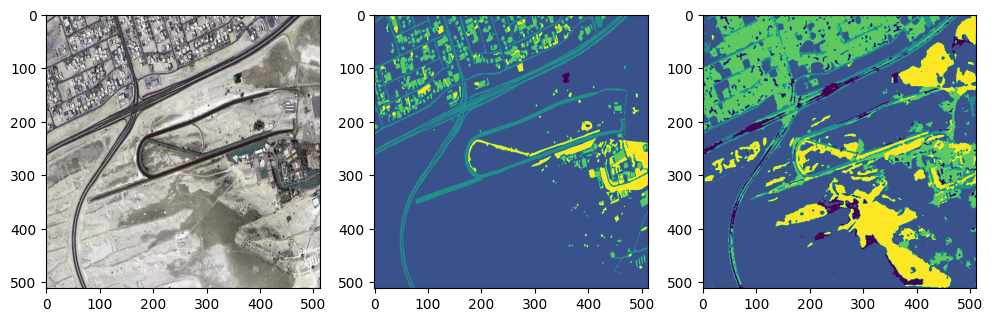

In [19]:
# Set the model to evaluation mode
model.eval()

# Iterate over batches in the test dataloader
for batch_i, (x, y) in enumerate(test_dataloader):
    # Iterate over samples in the batch
    for j in range(len(x)):
        # Forward pass: compute predicted output for the current sample
        result = model(x[j:j+1])

        # Extract predicted mask
        mask = torch.argmax(result, axis=1).cpu().detach().numpy()[0]

        # Convert input image to numpy array and move channels to the last dimension
        im = np.moveaxis(x[j].cpu().detach().numpy(), 0, -1).copy()*255
        im = im.astype(int)

        # Get ground truth mask
        gt_mask = y[j].cpu()

        # Plot input image, ground truth mask, and predicted mask
        plt.figure(figsize=(12,12))

        # Input image
        plt.subplot(1,3,1)
        im = np.moveaxis(x[j].cpu().detach().numpy(), 0, -1).copy()*255
        im = im.astype(int)
        plt.imshow(im)

        # Ground truth mask
        plt.subplot(1,3,2)
        plt.imshow(gt_mask)

        # Predicted mask
        plt.subplot(1,3,3)
        plt.imshow(mask)
        plt.show()

In [20]:
def precision(y, pred_mask, classes = 6):
    precision_list = [];
    for i in range(classes):
        actual_num = y.cpu() == i
        predicted_num = i == torch.argmax(pred_mask, axis=1).cpu()
        # Calculate precision for class i
        prec = torch.logical_and(actual_num,predicted_num).sum()/predicted_num.sum()
        precision_list.append(prec.numpy().tolist())
    return precision_list

def recall(y, pred_mask, classes = 6):
    recall_list = []
    for i in range(classes):
        actual_num = y.cpu() == i
        predicted_num = i == torch.argmax(pred_mask, axis=1).cpu()
        # Calculate recall for class i
        recall_val = torch.logical_and(actual_num, predicted_num).sum() / actual_num.sum()
        recall_list.append(recall_val.numpy().tolist())
    return recall_list

In [21]:
# Initialize lists to store predicted masks, ground truth masks, precisions, and recalls
pred_list = []
gt_list = []
precision_list = []
recall_list = []

# Iterate over batches in the test dataloader
for batch_i, (x, y) in enumerate(test_dataloader):
    # Iterate over samples in the batch
    for j in range(len(x)):
        # Forward pass: compute predicted output for the current sample
        result = model(x.to(device)[j:j+1])

        # Calculate precision and recall for the current sample and append to lists
        precision_list.append(precision(y[j],result))
        recall_list.append(recall(y[j],result))

In [22]:
# Calculate mean precision across all samples for each class, ignoring NaN values
print(f"Mean precision value of each class: {np.nanmean(precision_list,axis = 0)}")

Mean precision value of each class: [0.53924163 0.84512263 0.42757059 0.48931738 0.26948402        nan]


/tmp/ipykernel_33/2536740572.py:2: RuntimeWarning: Mean of empty slice
  print(f"Mean precision value of each class: {np.nanmean(precision_list,axis = 0)}")


In [23]:
# Calculate mean recall across all samples for each class, ignoring NaN values
print(f"Mean recall value of each class: {np.nanmean(recall_list,axis = 0)}")

Mean recall value of each class: [0.62643195 0.73644896 0.44029165 0.3532635  0.47848307 0.        ]


In [24]:
# Calculate the mean precision across all classes excluding the last one
final_precision = np.nanmean(precision_list,axis = 0)

# Sum the precision values of all classes except the last one and divide by 5
print(f"Final precision value: {sum(final_precision[:-1])/5}")

Final precision value: 0.5141472511109896


/tmp/ipykernel_33/856114680.py:2: RuntimeWarning: Mean of empty slice
  final_precision = np.nanmean(precision_list,axis = 0)


In [25]:
# Calculate the mean recall across all classes
final_recall = np.nanmean(recall_list,axis = 0)

# Sum the recall values of all classes and divide by 5
print(f"Final recall value: {sum(final_recall)/5}")

Final recall value: 0.5269838242638105


In [26]:
import numpy as np
from sklearn.metrics import confusion_matrix

def calculate_iou(confusion_matrix):
    intersection = np.diag(confusion_matrix)
    union = (confusion_matrix.sum(1) + confusion_matrix.sum(0)) - intersection
    iou = intersection / union.astype(np.float32)
    return iou.mean()

def calculate_mIoU(predicted, target):
    num_classes = max(np.max(target), np.max(predicted)) + 1
    confusion_mat = confusion_matrix(target.flatten(), predicted.flatten(), labels=range(num_classes))
    class_iou = calculate_iou(confusion_mat)
    return class_iou


model.eval()

total_mIoU = 0.0
total_batches = 0

for batch_i, (x, y) in enumerate(test_dataloader):

    for j in range(len(x)):

        result = model(x[j:j+1])

        mask = torch.argmax(result, axis=1).cpu().detach().numpy()[0]

        gt_mask = y[j].cpu().numpy()

        # Calculate mIoU for the current sample
        mIoU = calculate_mIoU(mask, gt_mask)
        total_mIoU += mIoU
        total_batches += 1

# Calculate average mIoU
average_mIoU = total_mIoU / total_batches
print("Average mIoU:", average_mIoU)

Average mIoU: 0.32247145878888145
